In [1]:
import numpy as np
from random import *

def tree():
    labels = []
    data = np.array([[None,None] for i in range(900)])
    flow = np.array([[None,None] for i in range(900)])
    
    for i in range(100):
        data[i][0] = np.random.uniform(0.0, 1.0)
        data[i][1] = np.random.uniform(1.0, 2.0)
        f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(-1.0, 1.0) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(0)
    for i in range(100,200):
        data[i][0] = np.random.uniform(0.0, 1.0)
        data[i][1] = np.random.uniform(-2.0, -1.0)
        f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(-1.0, 1.0) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(1)
    for i in range(200,300):
        data[i][0] = np.random.uniform(2.0, 3.0)
        data[i][1] = np.random.uniform(-1.0, 1.0)
        if(i < 250):
            f = [np.random.uniform(4.0, 5.0) - data[i][0], np.random.uniform(2.0, 3.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(4.0, 5.0) - data[i][0], np.random.uniform(-2.0, -1.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(2)
    for i in range(300,400):
        data[i][0] = np.random.uniform(4.0, 5.0)
        data[i][1] = np.random.uniform(2.0, 3.0)
        if(i < 250):
            f = [np.random.uniform(6.0, 7.0) - data[i][0], np.random.uniform(3.0, 4.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(6.0, 7.0) - data[i][0], np.random.uniform(1.0, 2.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(3)
    for i in range(400,500):
        data[i][0] = np.random.uniform(4.0, 5.0)
        data[i][1] = np.random.uniform(-2.0, -1.0)
        if(i < 250):
            f = [np.random.uniform(6.0, 7.0) - data[i][0], np.random.uniform(-2.0, -1.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(6.0, 7.0) - data[i][0], np.random.uniform(-4.0, -3.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(4)
    for i in range(500,600):
        data[i][0] = np.random.uniform(6.0, 7.0)
        data[i][1] = np.random.uniform(3.0, 4.0)
        flow[i] = [1,0]
        labels.append(5)
    for i in range(600,700):
        data[i][0] = np.random.uniform(6.0, 7.0)
        data[i][1] = np.random.uniform(1.0, 2.0)
        flow[i] = [1,0]
        labels.append(6)
    for i in range(700,800):
        data[i][0] = np.random.uniform(6.0, 7.0)
        data[i][1] = np.random.uniform(-2.0, -1.0)
        flow[i] = [1,0]
        labels.append(7)
    for i in range(800,900):
        data[i][0] = np.random.uniform(6.0, 7.0)
        data[i][1] = np.random.uniform(-4.0, -3.0)
        flow[i] = [1,0]
        labels.append(8)
        
    return np.array(data, dtype=float), np.array(flow, dtype=float), labels

In [2]:
data, flow, labels = tree()
np.shape(data)

(900, 2)

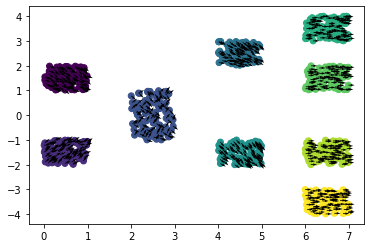

In [3]:
import matplotlib.pyplot as plt

plt.scatter(data[:,0], data[:,1], c = labels)
plt.quiver(data[:,0],data[:,1], flow[:,0], flow[:,1])

## Testing Flow Embedder

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from tqdm import trange
from directed_graphs.utils import diffusion_matrix_from_graph
import numpy as np
import matplotlib.pyplot as plt
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset

class DiffusionFlowEmbedder(torch.nn.Module):
	def __init__(self, X, flows, t = 4, sigma_graph = 0.5, sigma_embedding=0.5, embedding_dimension=2):
		"""Flow Embedding with diffusion

		Parameters
		----------
		X : torch tensor n_points x n_dim
			data matrix
		flows : torch tensor n_points x n_dim
			The flow at each point
		t : int
			Loss is computed with the diffusion operator powered to this number
		sigma in [0,1]
			Kernel bandwidth in the embedding
		"""
		# initialize parameters
		super(DiffusionFlowEmbedder, self).__init__()
		self.X = X
		self.ground_truth_flows = flows
		self.t = t
		self.sigma_embedding = sigma_embedding
		self.sigma_graph = sigma_graph
		self.nnodes = X.shape[0]
		self.data_dimension = X.shape[1]
		self.losses = []
		self.embedding_dimension = embedding_dimension
		# Compute P^t of the graph, the powered diffusion matrix
		# TODO: This can be optimized using landmarks, etc. For now it's straight sparse matrix multiplication
		# TODO: Migrate to a specialized function for dataset affinity calculation, with automatic kernel bandwidth selection, and the like
		self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph)
		self.P_graph_t = torch.matrix_power(self.P_graph,self.t)
		# Flow field
		self.FlowArtist = nn.Sequential(nn.Linear(2, 10),
		                       nn.ReLU(),
		                       nn.Linear(10, 10),
		                       nn.ReLU(),
		                       nn.Linear(10, 2))
		# Autoencoder to embed the points into a low dimension
		self.encoder = nn.Sequential(nn.Linear(self.data_dimension, 100),
															nn.ReLU(),
															nn.Linear(100, 10),
															nn.ReLU(),
															nn.Linear(10, self.embedding_dimension))
		self.decoder = nn.Sequential(nn.Linear(self.embedding_dimension, 10),
															nn.ReLU(),
															nn.Linear(10, 100),
															nn.ReLU(),
															nn.Linear(100, self.data_dimension))
		# training ops
		self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
		self.MSE = nn.MSELoss()
		self.optim = torch.optim.Adam(self.parameters())
									

	def compute_embedding_P(self):
		A = affinity_matrix_from_pointset_to_pointset(self.embedded_points,self.embedded_points,flows = self.FlowArtist(self.embedded_points), sigma = self.sigma_embedding)
		# flow
		self.P_embedding = torch.diag(1/A.sum(axis=1)) @ A
		# power it
		self.P_embedding_t = torch.matrix_power(self.P_embedding,self.t)

	def loss(self):
		self.embedded_points = self.encoder(self.X)
		# compute embedding diffusion matrix
		self.compute_embedding_P()
		# compute autoencoder loss
		X_reconstructed = self.decoder(self.embedded_points)
		reconstruction_loss = self.MSE(X_reconstructed, self.X)
		# take KL divergence between it and actual P
		log_P_embedding_t = torch.log(self.P_embedding_t)
		diffusion_loss = self.KLD(log_P_embedding_t,self.P_graph_t)
		cost = diffusion_loss + reconstruction_loss
		# print(f"cost is KLD {diffusion_loss} with recon {reconstruction_loss}")
		self.losses.append([diffusion_loss,reconstruction_loss])
		return cost

	def visualize_points(self, labels):
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		minx = min(self.embedded_points[:,0].detach().cpu().numpy())-1
		maxx = max(self.embedded_points[:,0].detach().cpu().numpy())+1
		miny = min(self.embedded_points[:,1].detach().cpu().numpy())-1
		maxy = max(self.embedded_points[:,1].detach().cpu().numpy())+1
		x, y = np.meshgrid(np.linspace(minx,maxx,20),np.linspace(miny,maxy,20))
		x = torch.tensor(x,dtype=float).cpu()
		y = torch.tensor(y,dtype=float).cpu()
		xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float().to('cuda')
		uv = self.FlowArtist(xy_t).detach()
		u = uv[:,:,0].cpu()
		v = uv[:,:,1].cpu()
		

		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		
		sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
		plt.quiver(x,y,u,v)
		plt.legend(labels = set(labels))
		# Display all open figures.
		plt.show()


	def fit(self,n_steps = 1000):
		# train Flow Embedder on the provided graph
		self.train()
		for step in trange(n_steps):
			self.optim.zero_grad()
			# compute loss
			loss = self.loss()
			# print("loss is ",loss)
			# compute gradient and step backwards
			loss.backward()
			self.optim.step()
			# TODO: Criteria to automatically end training
		print("Exiting training with loss ",loss)
		return self.embedded_points
    
if torch.__version__[:4] == "1.13":
	device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
else:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
X = torch.tensor(data)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [6]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:29<00:00, 68.94it/s]

Exiting training with loss  tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


/gpfs/ysm/project/sumry2022/sumry2022_gt392/conda_envs/test/lib/python3.9/site-packages/matplotlib/quiver.py:633: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/gpfs/ysm/project/sumry2022/sumry2022_gt392/conda_envs/test/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


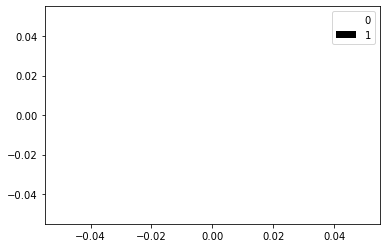

In [7]:
dfe.visualize_points(labels)

In [8]:
def tree2():
    labels = []
    data = np.array([[None,None] for i in range(1800)])
    flow = np.array([[None,None] for i in range(1800)])
    
    for i in range(200):
        data[i][0] = np.random.uniform(0.0, 1.0)
        data[i][1] = np.random.uniform(0.0, 1.0)
        f = [np.random.uniform(1.0, 2.0) - data[i][0], np.random.uniform(-0.5, 0.5) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(0)
    for i in range(200,400):
        data[i][0] = np.random.uniform(0.0, 1.0)
        data[i][1] = np.random.uniform(-1.0, 0.0)
        f = [np.random.uniform(1.0, 2.0) - data[i][0], np.random.uniform(-0.5, 0.5) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(1)
    for i in range(400,600):
        data[i][0] = np.random.uniform(1.0, 2.0)
        data[i][1] = np.random.uniform(-0.5, 0.5)
        if(i < 250):
            f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(0.0, 1.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(-1.0, 0.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(2)
    for i in range(600,800):
        data[i][0] = np.random.uniform(2.0, 3.0)
        data[i][1] = np.random.uniform(0.0, 1.0)
        if(i < 250):
            f = [np.random.uniform(3.0, 4.0) - data[i][0], np.random.uniform(1.5, 2.5) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(3.0, 4.0) - data[i][0], np.random.uniform(0.0, 1.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(3)
    for i in range(800,1000):
        data[i][0] = np.random.uniform(2.0, 3.0)
        data[i][1] = np.random.uniform(-1.0, 0.0)
        if(i < 250):
            f = [np.random.uniform(3.0, 4.0) - data[i][0], np.random.uniform(-1.0, 0.0) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        else:
            f = [np.random.uniform(3.0, 4.0) - data[i][0], np.random.uniform(-2.5, -1.5) - data[i][1]]
            flow[i] = f/np.linalg.norm(f)
        labels.append(4)
    for i in range(1000,1200):
        data[i][0] = np.random.uniform(3.0, 4.0)
        data[i][1] = np.random.uniform(1.5, 2.5)
        flow[i] = [1,0]
        labels.append(5)
    for i in range(1200,1400):
        data[i][0] = np.random.uniform(3.0, 4.0)
        data[i][1] = np.random.uniform(0.0, 1.0)
        flow[i] = [1,0]
        labels.append(6)
    for i in range(1400,1600):
        data[i][0] = np.random.uniform(3.0, 4.0)
        data[i][1] = np.random.uniform(-1.0, 0.0)
        flow[i] = [1,0]
        labels.append(7)
    for i in range(1600,1800):
        data[i][0] = np.random.uniform(3.0, 4.0)
        data[i][1] = np.random.uniform(-2.5, -1.5)
        flow[i] = [1,0]
        labels.append(8)
        
    return np.array(data, dtype=float), np.array(flow, dtype=float), labels

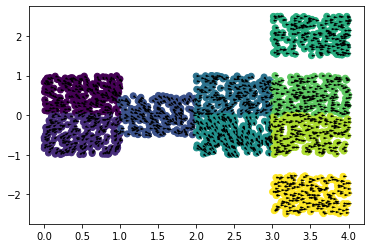

In [9]:
data, flow, labels = tree2()

plt.scatter(data[:,0], data[:,1], c = labels)
plt.quiver(data[:,0],data[:,1], flow[:,0], flow[:,1])

In [10]:
X = torch.tensor(data)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [11]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:26<00:00, 74.32it/s]

Exiting training with loss  tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


In [34]:
dfe.embedded_points

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>)

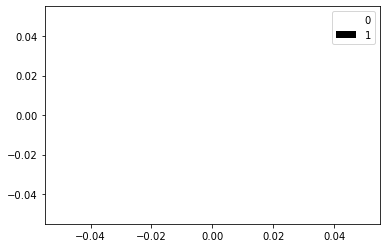

In [12]:
dfe.visualize_points(labels)

## Test Auto-Encoder

In [13]:
data, flow, labels = tree()

np.shape(flow)

(900, 2)

In [14]:
for i in range(900):
    flow[i] = [0,0]

np.shape(flow)

(900, 2)

/gpfs/ysm/project/sumry2022/sumry2022_gt392/conda_envs/test/lib/python3.9/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/gpfs/ysm/project/sumry2022/sumry2022_gt392/conda_envs/test/lib/python3.9/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


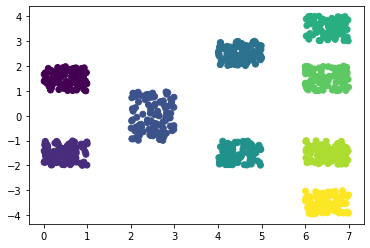

In [15]:
plt.scatter(data[:,0], data[:,1], c = labels)
plt.quiver(data[:,0],data[:,1], flow[:,0], flow[:,1])

In [16]:
X = torch.tensor(data)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [17]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:26<00:00, 75.49it/s]

Exiting training with loss  tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


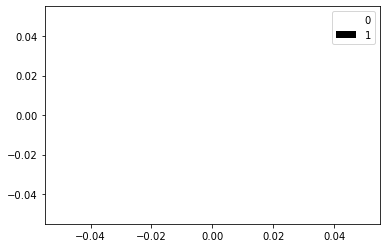

In [18]:
dfe.visualize_points(labels)

In [19]:
data, flow, labels = tree2()
for i in range(1800):
    flow[i] = [0,0]

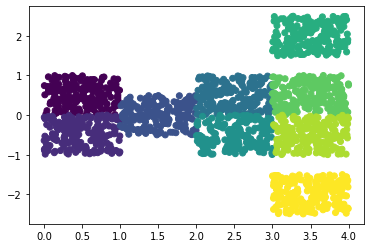

In [20]:
plt.scatter(data[:,0], data[:,1], c = labels)
plt.quiver(data[:,0],data[:,1], flow[:,0], flow[:,1])

In [21]:
X = torch.tensor(data)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [22]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:26<00:00, 75.17it/s]

Exiting training with loss  tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


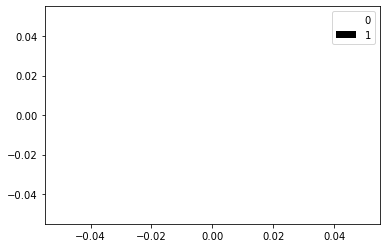

In [23]:
dfe.visualize_points(labels)

## Regular Tree

In [24]:
def treeReg():
    labels = []
    data = np.array([[None,None] for i in range(1200)])
    flow = np.array([[None,None] for i in range(1200)])
    
    for i in range(200):
        data[i][0] = np.random.uniform(-0.5, 0.5)
        data[i][1] = np.random.uniform(0.0, 1.0)
        if(i < 100):
            f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(1.0, 2.0) - data[i][1]]
        else:
            f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(-2.0, 1.0) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(0)
    for i in range(200,400):
        data[i][0] = np.random.uniform(2.0, 3.0)
        data[i][1] = np.random.uniform(1.0, 2.0)
        f = [np.random.uniform(4.0, 5.0) - data[i][0], np.random.uniform(1.0, 2.0) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(1)
    for i in range(400,600):
        data[i][0] = np.random.uniform(2.0, 3.0)
        data[i][1] = np.random.uniform(-2.0, -1.0)
        if(i < 100):
            f = [np.random.uniform(4.0, 5.0) - data[i][0], np.random.uniform(-2.0, 1.0) - data[i][1]]
        else:
            f = [np.random.uniform(4.0, 5.0) - data[i][0], np.random.uniform(-4.0, -3.0) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(2)
    for i in range(600,800):
        data[i][0] = np.random.uniform(4.0, 5.0)
        data[i][1] = np.random.uniform(1.0, 2.0)
        f = [1,0]
        flow[i] = f/np.linalg.norm(f)
        labels.append(3)
    for i in range(800,1000):
        data[i][0] = np.random.uniform(4.0, 5.0)
        data[i][1] = np.random.uniform(-2.0, -1.0)
        f = [1,0]
        flow[i] = f/np.linalg.norm(f)
        labels.append(4)
    for i in range(1000,1200):
        data[i][0] = np.random.uniform(4.0, 5.0)
        data[i][1] = np.random.uniform(-4.0, -3.0)
        f = [1,0]
        flow[i] = f/np.linalg.norm(f)
        labels.append(5)
        
    return np.array(data, dtype=float), np.array(flow, dtype=float), labels

In [25]:
data, flow, labels = treeReg()

print(np.shape(data))
print(np.shape(flow))
print(np.shape(labels))

(1200, 2)
(1200, 2)
(1200,)


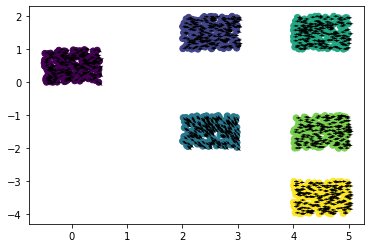

In [26]:
plt.scatter(data[:,0], data[:,1], c = labels)
plt.quiver(data[:,0],data[:,1], flow[:,0], flow[:,1])

In [27]:
X = torch.tensor(data)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [28]:
dfe = DiffusionFlowEmbedder(X,flow,t=1,sigma_graph=15,sigma_embedding=15)
dfe = dfe.to(device)
embeddings = dfe.fit(n_steps=2000)

100%|██████████| 2000/2000 [00:26<00:00, 75.43it/s]

Exiting training with loss  tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


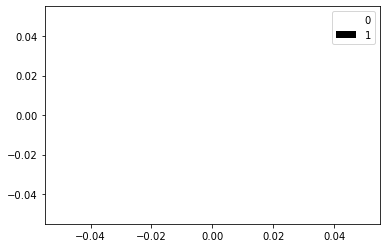

In [29]:
dfe.visualize_points(labels)

## Multi-tree

In [30]:
def treeMulti():
    labels = []
    data = np.array([[None,None] for i in range(1200)])
    flow = np.array([[None,None] for i in range(1200)])
    
    for i in range(300):
        data[i][0] = np.random.uniform(0.0, 1.0)
        data[i][1] = np.random.uniform(0.5, 1.5)
        if(i < 100):
            f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(0.5, 1.5) - data[i][1]]
        else:
            f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(-1.5, 0.5) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(0)
    for i in range(300,600):
        data[i][0] = np.random.uniform(0.0, 1.0)
        data[i][1] = np.random.uniform(-1.5, -0.5)
        if(i < 100):
            f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(0.5, 1.5) - data[i][1]]
        else:
            f = [np.random.uniform(2.0, 3.0) - data[i][0], np.random.uniform(-1.5, 0.5) - data[i][1]]
        flow[i] = f/np.linalg.norm(f)
        labels.append(1)
    for i in range(600,900):
        data[i][0] = np.random.uniform(2.0, 3.0)
        data[i][1] = np.random.uniform(0.5, 1.5)
        f = [1,0]
        flow[i] = f/np.linalg.norm(f)
        labels.append(2)
    for i in range(900,1200):
        data[i][0] = np.random.uniform(2.0, 3.0)
        data[i][1] = np.random.uniform(-1.5, -0.5)
        f = [1,0]
        flow[i] = f/np.linalg.norm(f)
        labels.append(3)
        
    return np.array(data, dtype=float), np.array(flow, dtype=float), labels

In [31]:
data, flow, labels = treeMulti()

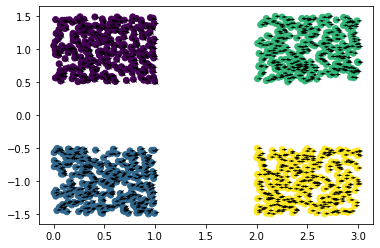

In [32]:
plt.scatter(data[:,0], data[:,1], c = labels)
plt.quiver(data[:,0],data[:,1], flow[:,0], flow[:,1])